In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Show plots inline
%matplotlib inline

# Load feature table
df = pd.read_parquet("/Users/tanvipatel/Desktop/citysense/data/interim/feature_table.parquet")
df.head()


,date,complaints_city,temp_avg_c,temp_min_c,temp_max_c,precip_mm,snow_mm,wdir,wind_kmh,wpgt,pressure_hpa,tsun,is_holiday,holiday_name
0,2023-01-01,6209,8.1,4.6,10.6,0.0,0.0,<NA>,9.4,<NA>,1013.5,<NA>,True,New Year's Day
1,2023-01-02,6677,7.5,4.2,12.3,1.3,0.0,<NA>,7.4,<NA>,1020.1,<NA>,True,New Year's Day (observed)
2,2023-01-03,8254,10.2,7.9,13.6,11.4,0.0,<NA>,5.7,<NA>,1014.9,<NA>,False,None
3,2023-01-04,8462,13.0,10.2,17.1,0.5,0.0,<NA>,10.4,<NA>,1010.8,<NA>,False,None
4,2023-01-05,8412,10.9,7.9,13.7,0.0,0.0,<NA>,11.5,<NA>,1014.1,<NA>,False,None


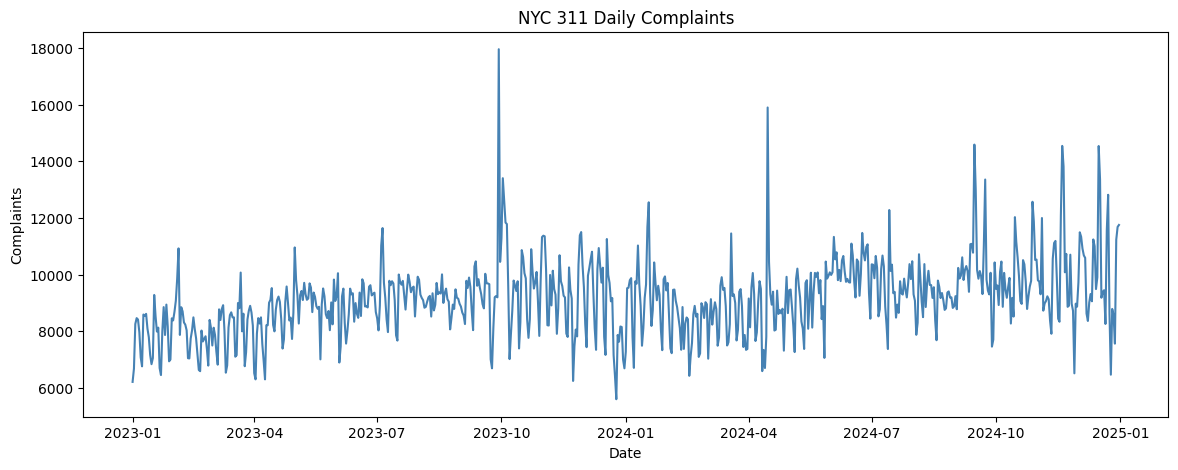

In [2]:
plt.figure(figsize=(14,5))
plt.plot(df["date"], df["complaints_city"], color="steelblue")
plt.title("NYC 311 Daily Complaints")
plt.xlabel("Date")
plt.ylabel("Complaints")
plt.show()

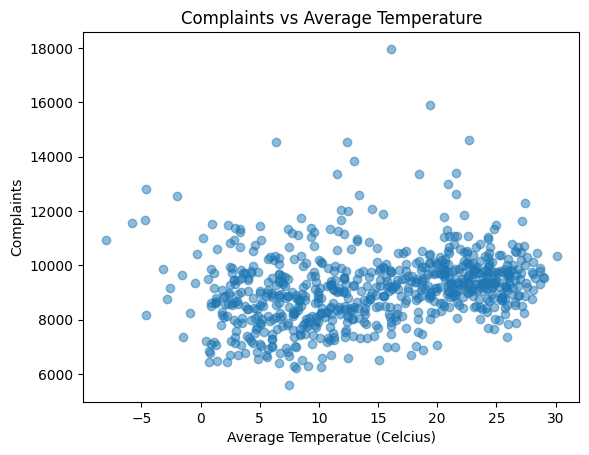

In [3]:
plt.scatter(df["temp_avg_c"], df["complaints_city"], alpha=0.5)
plt.title("Complaints vs Average Temperature")
plt.xlabel("Average Temperatue (Celcius)")
plt.ylabel("Complaints")
plt.show()

In [4]:
holiday_means = df.groupby("is_holiday")["complaints_city"].mean()
holiday_means.index = holiday_means.index.map({True:"Holiday", False: "Non-holiday"})
holiday_means

is_holiday
Non-holiday    9194.532857
Holiday        7990.451613
Name: complaints_city, dtype: float64

In [5]:
df = pd.read_parquet("/Users/tanvipatel/Desktop/citysense/data/interim/feature_table.parquet").copy()

df["date"] = pd.to_datetime(df["date"])
df["dow"] = df["date"].dt.dayofweek
df["is_weekend"] = df["dow"].isin([5,6]).astype(int)
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

df.head()

,date,complaints_city,temp_avg_c,temp_min_c,temp_max_c,precip_mm,snow_mm,wdir,wind_kmh,wpgt,pressure_hpa,tsun,is_holiday,holiday_name,dow,is_weekend,month,year
0,2023-01-01,6209,8.1,4.6,10.6,0.0,0.0,<NA>,9.4,<NA>,1013.5,<NA>,True,New Year's Day,6,1,1,2023
1,2023-01-02,6677,7.5,4.2,12.3,1.3,0.0,<NA>,7.4,<NA>,1020.1,<NA>,True,New Year's Day (observed),0,0,1,2023
2,2023-01-03,8254,10.2,7.9,13.6,11.4,0.0,<NA>,5.7,<NA>,1014.9,<NA>,False,None,1,0,1,2023
3,2023-01-04,8462,13.0,10.2,17.1,0.5,0.0,<NA>,10.4,<NA>,1010.8,<NA>,False,None,2,0,1,2023
4,2023-01-05,8412,10.9,7.9,13.7,0.0,0.0,<NA>,11.5,<NA>,1014.1,<NA>,False,None,3,0,1,2023


In [6]:
missing_pct = df.isna().mean().sort_values(ascending=False)
missing_pct

wpgt               1.000000
wdir               1.000000
tsun               1.000000
holiday_name       0.957592
pressure_hpa       0.000000
month              0.000000
is_weekend         0.000000
dow                0.000000
is_holiday         0.000000
date               0.000000
complaints_city    0.000000
wind_kmh           0.000000
snow_mm            0.000000
precip_mm          0.000000
temp_max_c         0.000000
temp_min_c         0.000000
temp_avg_c         0.000000
year               0.000000
dtype: float64

In [7]:
to_drop = [c for c in ["wdir", "wpgt", "tsun"] if c in df.columns]
df = df.drop(columns=to_drop)
to_drop

['wdir', 'wpgt', 'tsun']

In [8]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
target = "complaints_city"
num_features = [c for c in num_cols if c!= target]
df[num_features] = df[num_features].ffill().bfill()
df[num_features] = df[num_features].fillna(df[num_features].median())
df.isna().sum().sort_values(ascending=False).head(10)

holiday_name       700
date                 0
complaints_city      0
temp_avg_c           0
temp_min_c           0
temp_max_c           0
precip_mm            0
snow_mm              0
wind_kmh             0
pressure_hpa         0
dtype: int64

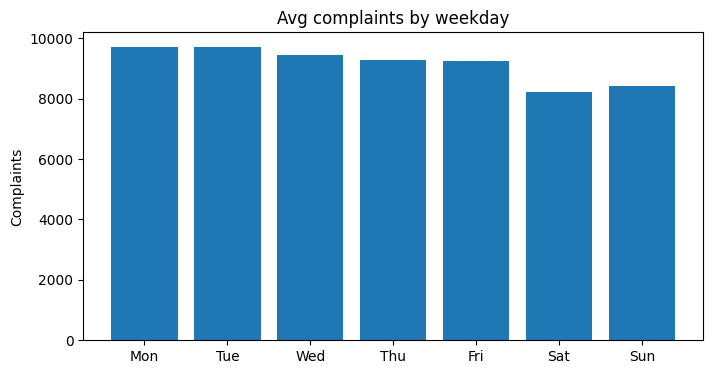

holiday_label
Holiday        7990.451613
Non-holiday    9194.532857
Name: complaints_city, dtype: float64

In [9]:
weekday_mean = df.groupby("dow")[target].mean()
weekday_labels = ["Mon", "Tue","Wed","Thu","Fri","Sat","Sun"]
plt.figure(figsize=(8,4))
plt.bar(weekday_labels, weekday_mean.sort_index().values)
plt.title("Avg complaints by weekday")
plt.ylabel("Complaints")
plt.show()

df["holiday_label"] = df["is_holiday"].map({True: "Holiday", False: "Non-holiday"})
holiday_mean = df.groupby("holiday_label")[target].mean()
holiday_mean

In [10]:
corr = df.select_dtypes(include=[np.number]).corr()[[target]].sort_values(by=target, ascending=False)
corr.head(12)

,complaints_city
complaints_city,1.000000
month,0.353030
temp_max_c,0.251290
temp_avg_c,0.241462
year,0.229895
temp_min_c,0.228098
pressure_hpa,0.110522
snow_mm,-0.037955
wind_kmh,-0.042008
precip_mm,-0.058700


In [11]:
out_path = "/Users/tanvipatel/Desktop/citysense/data/processed/model_table.parquet"
df.to_parquet(out_path, index=False)
out_path

'/Users/tanvipatel/Desktop/citysense/data/processed/model_table.parquet'

In [12]:
TARGET = "complaints_city"
df = pd.read_parquet("/Users/tanvipatel/Desktop/citysense/data/processed/model_table.parquet").copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
if "holiday_label" not in df.columns and "is_holiday" in df.columns:
    df["holiday_label"] = df["is_holiday"].map({True: "Holiday", False: "Non-holiday"})

df["lag1"] = df[TARGET].shift(1)
df["lag7"] = df[TARGET].shift(7)
df["roll7_mean"] = df[TARGET].shift(1).rolling(7).mean()
df["dow"] = df["date"].dt.dayofweek

df = df.dropna(subset=["lag1", "lag7", "roll7_mean"]).reset_index(drop=True)
df.head()

,date,complaints_city,temp_avg_c,temp_min_c,temp_max_c,precip_mm,snow_mm,wind_kmh,pressure_hpa,is_holiday,holiday_name,dow,is_weekend,month,year,holiday_label,lag1,lag7,roll7_mean
0,2023-01-08,6759,0.8,-2.3,2.8,0.2,0.0,8.1,1025.1,False,None,6,1,1,2023,Non-holiday,7075.0,6209.0,7578.714286
1,2023-01-09,8589,3.2,1.1,7.5,0.3,0.0,9.4,1014.8,False,None,0,0,1,2023,Non-holiday,6759.0,6677.0,7657.285714
2,2023-01-10,8548,2.7,-0.1,6.4,0.7,0.0,11.1,1017.8,False,None,1,0,1,2023,Non-holiday,8589.0,8254.0,7930.428571
3,2023-01-11,8613,0.9,-1.6,3.6,0.0,0.0,13.7,1023.8,False,None,2,0,1,2023,Non-holiday,8548.0,8462.0,7972.428571
4,2023-01-12,8092,6.4,0.4,10.8,5.3,0.0,14.7,1017.2,False,None,3,0,1,2023,Non-holiday,8613.0,8412.0,7994.000000


In [13]:
VALID_DAYS = 90
cutoff = df["date"].max() - pd.Timedelta(days=VALID_DAYS)

train = df[df["date"] <= cutoff].copy()
valid = df[df["date"] > cutoff].copy()

len(train), len(valid), train["date"].min(), train["date"].max(), valid["date"].min(), valid["date"].max()

(634,
 90,
 Timestamp('2023-01-08 00:00:00'),
 Timestamp('2024-10-02 00:00:00'),
 Timestamp('2024-10-03 00:00:00'),
 Timestamp('2024-12-31 00:00:00'))

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    # Version-proof RMSE: take sqrt of MSE (no 'squared' kwarg)
    return np.sqrt(mean_squared_error(y_true, y_pred))

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom[denom == 0] = 1e-9
    return np.mean(np.abs(y_true - y_pred) / denom) * 100


In [15]:
y_true = valid[TARGET].values
y_pred_naive = valid["lag1"].values

print("Naive (yesterday) baseline")
print("MAE :", mean_absolute_error(y_true, y_pred_naive))
print("RMSE:", rmse(y_true, y_pred_naive))
print("sMAPE ()%:", smape(y_true, y_pred_naive))

Naive (yesterday) baseline
MAE : 1154.3333333333333
RMSE: 1628.7369271241373
sMAPE ()%: 11.583317456687999


In [16]:
from sklearn.linear_model import LinearRegression

feature_cols = [
    "lag1","lag7","roll7_mean","dow",
]

# Add a couple of weather features if present
for c in ["temp_avg_c","precip_mm","wind_kmh","pressure_hpa"]:
    if c in df.columns:
        feature_cols.append(c)

X_train = train[feature_cols]
X_valid = valid[feature_cols]
y_train = train[TARGET]
y_valid = valid[TARGET]

lin = LinearRegression()
lin.fit(X_train, y_train)
pred_lr = lin.predict(X_valid)

print("Linear Regression")
print("MAE :", mean_absolute_error(y_valid, pred_lr))
print("RMSE:", rmse(y_valid, pred_lr))
print("sMAPE (%):", smape(y_valid, pred_lr))
feature_cols


Linear Regression
MAE : 1067.3119914257825
RMSE: 1405.8372408219846
sMAPE (%): 10.669942909911667


['lag1',
 'lag7',
 'roll7_mean',
 'dow',
 'temp_avg_c',
 'precip_mm',
 'wind_kmh',
 'pressure_hpa']

In [17]:
import pandas as pd
comp = pd.DataFrame({
    "model": ["Naive (lag1)", "Linear Regression"],
    "MAE": [
        mean_absolute_error(y_true, y_pred_naive),
        mean_absolute_error(y_valid, pred_lr),
    ],
    "RMSE": [
        rmse(y_true, y_pred_naive),
        rmse(y_valid, pred_lr),
    ],
    "sMAPE_%": [
        smape(y_true, y_pred_naive),
        smape(y_valid, pred_lr),
    ],
})
comp


,model,MAE,RMSE,sMAPE_%
0,Naive (lag1),1154.333333,1628.736927,11.583317
1,Linear Regression,1067.311991,1405.837241,10.669943


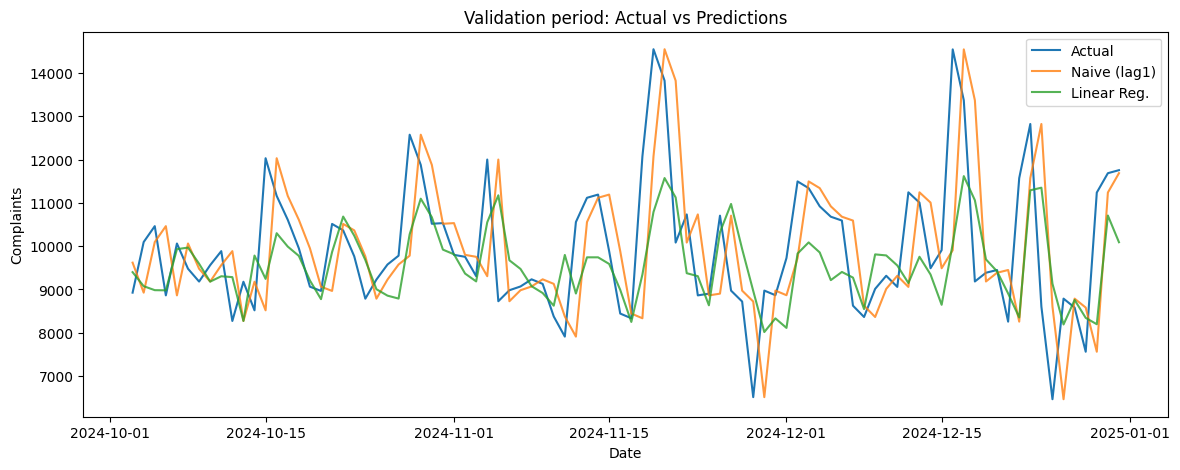

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(valid["date"], y_true, label="Actual")
plt.plot(valid["date"], y_pred_naive, label="Naive (lag1)", alpha=0.8)
plt.plot(valid["date"], pred_lr, label="Linear Reg.", alpha=0.8)
plt.title("Validation period: Actual vs Predictions")
plt.xlabel("Date")
plt.ylabel("Complaints")
plt.legend()
plt.show()


Residuals — Naive: mean= 23.73 std= 1628.56
Residuals — Linear: mean= 379.79 std= 1353.56


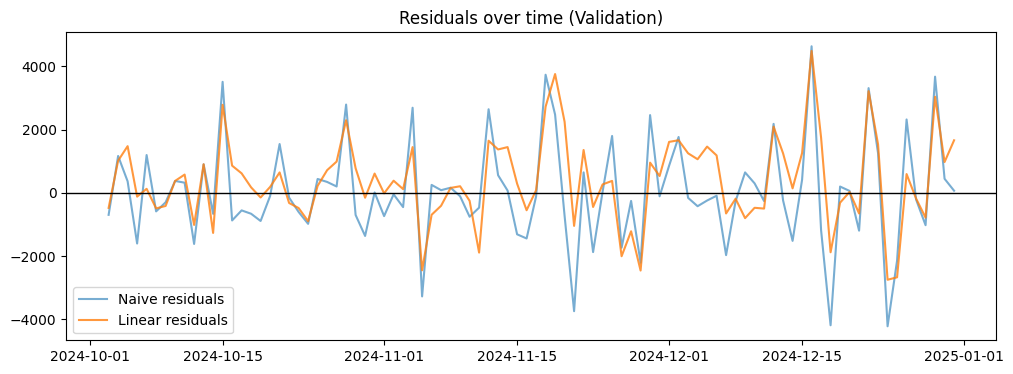

In [19]:
import numpy as np
import matplotlib.pyplot as plt

res_naive = y_true - y_pred_naive
res_lr    = y_true - pred_lr

print("Residuals — Naive: mean=", np.round(res_naive.mean(),2), "std=", np.round(res_naive.std(),2))
print("Residuals — Linear: mean=", np.round(res_lr.mean(),2), "std=", np.round(res_lr.std(),2))

plt.figure(figsize=(12,4))
plt.plot(valid["date"], res_naive, label="Naive residuals", alpha=0.6)
plt.plot(valid["date"], res_lr, label="Linear residuals", alpha=0.8)
plt.axhline(0, color="black", linewidth=1)
plt.title("Residuals over time (Validation)")
plt.legend(); plt.show()


In [20]:
# Start from the full, sorted df again to build new features safely
full = pd.read_parquet("/Users/tanvipatel/Desktop/citysense/data/processed/model_table.parquet").copy()
full["date"] = pd.to_datetime(full["date"])
full = full.sort_values("date")

TARGET = "complaints_city"

# Lags & rolling windows (shift before rolling to avoid peeking)
full["lag1"]  = full[TARGET].shift(1)
full["lag7"]  = full[TARGET].shift(7)
full["lag14"] = full[TARGET].shift(14)
full["lag28"] = full[TARGET].shift(28)

full["roll7_mean"]  = full[TARGET].shift(1).rolling(7).mean()
full["roll7_std"]   = full[TARGET].shift(1).rolling(7).std()
full["roll28_mean"] = full[TARGET].shift(1).rolling(28).mean()
full["roll28_std"]  = full[TARGET].shift(1).rolling(28).std()

# Calendar features
full["dow"]    = full["date"].dt.dayofweek
full["month"]  = full["date"].dt.month
full["is_wend"]= full["dow"].isin([5,6]).astype(int)

# Minimal NA drop for new features
full = full.dropna().reset_index(drop=True)

# Recreate train/valid split (last 90 days for validation)
cutoff = full["date"].max() - pd.Timedelta(days=90)
train = full[full["date"] <= cutoff].copy()
valid = full[full["date"] >  cutoff].copy()

y_train = train[TARGET].values
y_valid = valid[TARGET].values

base_features = [
    "lag1","lag7","lag14","lag28",
    "roll7_mean","roll7_std","roll28_mean","roll28_std",
    "dow","month","is_wend"
]

# add safe weather columns if present
for c in ["temp_avg_c","precip_mm","wind_kmh","pressure_hpa","snow_mm"]:
    if c in full.columns:
        base_features.append(c)

X_train = train[base_features]
X_valid = valid[base_features]
len(train), len(valid), X_train.shape, X_valid.shape


(23, 5, (23, 16), (5, 16))

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_valid)

def rmse_np(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

print("Random Forest")
print("MAE :", mean_absolute_error(y_valid, pred_rf))
print("RMSE:", rmse_np(y_valid, pred_rf))


Random Forest
MAE : 911.6714999999995
RMSE: 1075.8626508254895


In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# ---------- load & sort ----------
TARGET = "complaints_city"
full = pd.read_parquet("/Users/tanvipatel/Desktop/citysense/data/processed/model_table.parquet").copy()
full["date"] = pd.to_datetime(full["date"])
full = full.sort_values("date")

# ---------- build features (no leakage) ----------
full["lag1"]  = full[TARGET].shift(1)
full["lag7"]  = full[TARGET].shift(7)
full["lag14"] = full[TARGET].shift(14)
full["lag28"] = full[TARGET].shift(28)

full["roll7_mean"]  = full[TARGET].shift(1).rolling(7).mean()
full["roll7_std"]   = full[TARGET].shift(1).rolling(7).std()
full["roll28_mean"] = full[TARGET].shift(1).rolling(28).mean()
full["roll28_std"]  = full[TARGET].shift(1).rolling(28).std()

full["dow"]    = full["date"].dt.dayofweek
full["month"]  = full["date"].dt.month
full["is_wend"]= full["dow"].isin([5,6]).astype(int)

# optional weather features if present
extra_feats = [c for c in ["temp_avg_c","precip_mm","wind_kmh","pressure_hpa","snow_mm"] if c in full.columns]

# drop rows without full history
full = full.dropna().reset_index(drop=True)

# ---------- consistent time split ----------
VALID_DAYS = 90
cutoff = full["date"].max() - pd.Timedelta(days=VALID_DAYS)
train = full[full["date"] <= cutoff].copy()
valid = full[full["date"] >  cutoff].copy()

# features to use
feature_cols = [
    "lag1","lag7","lag14","lag28",
    "roll7_mean","roll7_std","roll28_mean","roll28_std",
    "dow","month","is_wend",
] + extra_feats

X_train = train[feature_cols]
X_valid = valid[feature_cols]
y_train = train[TARGET].values
y_valid = valid[TARGET].values

# ---------- models ----------
# Naive baseline (yesterday)
y_pred_naive = valid["lag1"].values

# Linear Regression
lin = LinearRegression()
lin.fit(X_train, y_train)
pred_lr = lin.predict(X_valid)

# Random Forest
rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_valid)

# ---------- metrics ----------
def rmse_np(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom[denom == 0] = 1e-9
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

import pandas as pd
comp = pd.DataFrame({
    "model": ["Naive (lag1)", "Linear Regression", "Random Forest"],
    "MAE": [
        mean_absolute_error(y_valid, y_pred_naive),
        mean_absolute_error(y_valid, pred_lr),
        mean_absolute_error(y_valid, pred_rf),
    ],
    "RMSE": [
        rmse_np(y_valid, y_pred_naive),
        rmse_np(y_valid, pred_lr),
        rmse_np(y_valid, pred_rf),
    ],
    "sMAPE_%": [
        smape(y_valid, y_pred_naive),
        smape(y_valid, pred_lr),
        smape(y_valid, pred_rf),
    ],
})
comp


,model,MAE,RMSE,sMAPE_%
0,Naive (lag1),1749.000000,2040.229056,20.428193
1,Linear Regression,1639.792165,1885.924591,20.003726
2,Random Forest,911.671500,1075.862651,11.947074


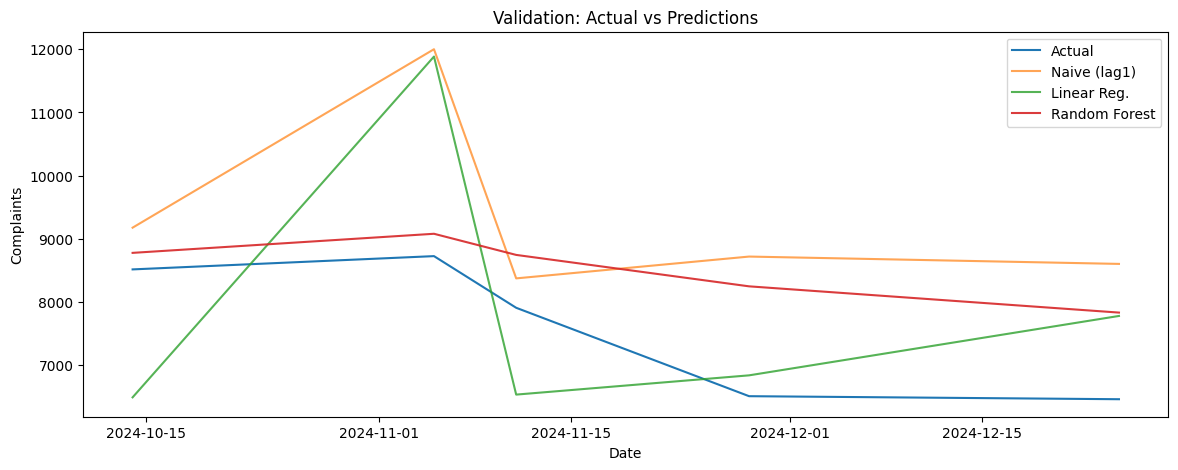

In [23]:
plt.figure(figsize=(14,5))
plt.plot(valid["date"], y_valid, label="Actual")
plt.plot(valid["date"], y_pred_naive, label="Naive (lag1)", alpha=0.7)
plt.plot(valid["date"], pred_lr, label="Linear Reg.", alpha=0.8)
plt.plot(valid["date"], pred_rf, label="Random Forest", alpha=0.9)
plt.title("Validation: Actual vs Predictions")
plt.xlabel("Date"); plt.ylabel("Complaints"); plt.legend(); plt.show()


In [24]:
from pathlib import Path
from joblib import dump

# ensure directories exist (relative to project root)
models_dir = Path("/Users/tanvipatel/Desktop/citysense/models")
models_dir.mkdir(parents=True, exist_ok=True)

processed_dir = Path("/Users/tanvipatel/Desktop/citysense/data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

# save the trained model
dump(rf, models_dir / "random_forest_daily.joblib")

# build prediction outputs
pred_out = valid[["date", TARGET]].copy()
pred_out["pred_naive"] = y_pred_naive
pred_out["pred_lr"]    = pred_lr
pred_out["pred_rf"]    = pred_rf

# save predictions in both formats
pred_out.to_parquet(processed_dir / "validation_preds.parquet", index=False)
pred_out.to_csv(processed_dir / "validation_preds.csv", index=False)  # Tableau-friendly

"Saved model & predictions."


'Saved model & predictions.'

In [25]:
from joblib import load
rf_loaded = load("/Users/tanvipatel/Desktop/citysense/models/random_forest_daily.joblib")

# check it predicts same as before
print("Reloaded model gives same results:",
      (rf_loaded.predict(X_valid[:5]) == pred_rf[:5]).all())


Reloaded model gives same results: True


In [26]:
import pandas as pd

feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_imp.sort_values(ascending=False).head(15)


lag1            0.242703
temp_avg_c      0.164629
wind_kmh        0.107867
lag7            0.095368
lag14           0.073172
roll28_mean     0.056142
precip_mm       0.052869
pressure_hpa    0.052755
roll28_std      0.044471
roll7_mean      0.029092
month           0.025208
roll7_std       0.024181
lag28           0.016248
dow             0.014259
snow_mm         0.000565
dtype: float64

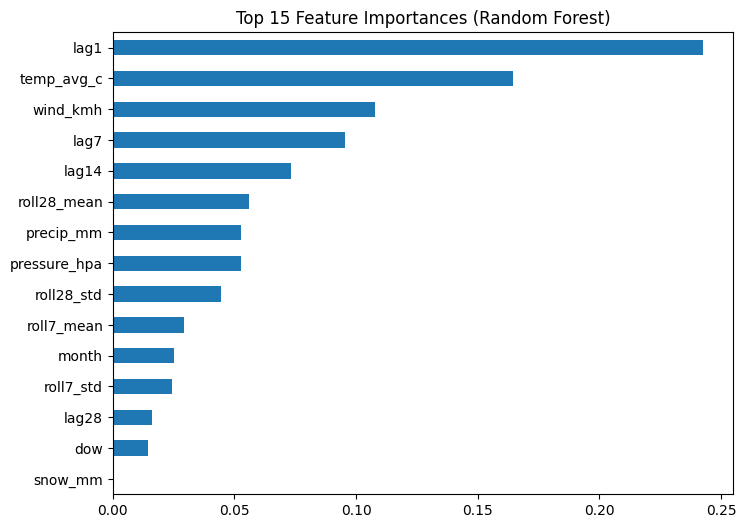

In [27]:
import matplotlib.pyplot as plt

feat_imp.sort_values(ascending=True).tail(15).plot.barh(figsize=(8,6))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


In [29]:
df = pd.read_parquet("/Users/tanvipatel/Desktop/citysense/data/processed/model_table.parquet")

# keep only relevant columns
cols = [
    "date", "complaints_city",
    "temp_avg_c","precip_mm","snow_mm","wind_kmh","pressure_hpa",
    "is_holiday","holiday_name"
]
df = df[cols]

# save for Tableau
df.to_csv("/Users/tanvipatel/Desktop/citysense/data/processed/complaints_features.csv", index=False)
"Exported complaints_features.csv for Tableau"


'Exported complaints_features.csv for Tableau'